### Test SNL with transformed MCMC sampling

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import pytest
import torch
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

import sbi.utils as utils
from sbi.inference import SNL, prepare_for_sbi
from sbi.simulators.linear_gaussian import (
    diagonal_linear_gaussian,
    linear_gaussian,
    samples_true_posterior_linear_gaussian_mvn_prior_different_dims,
    samples_true_posterior_linear_gaussian_uniform_prior,
    true_posterior_linear_gaussian_mvn_prior,
)

from sbi.utils.get_nn_models import get_vi_net
from sbi.utils.vi import train_vi, train_mle

In [38]:
num_dim = 3

x_o = zeros((1, num_dim))
num_samples = 500

# likelihood_mean will be likelihood_shift+theta
likelihood_shift = -1.0 * ones(num_dim)
likelihood_cov = 0.3 * eye(num_dim)

prior = utils.BoxUniform(-1.73 * ones(num_dim), 1.73 * ones(num_dim))
target_samples = samples_true_posterior_linear_gaussian_uniform_prior(
    x_o, likelihood_shift, likelihood_cov, prior=prior, num_samples=num_samples
)

simulator = lambda theta: linear_gaussian(theta, likelihood_shift, likelihood_cov)

infer = SNL(
    *prepare_for_sbi(simulator, prior),
    mcmc_method="slice",
    show_progress_bars=True,
)

posterior = infer(num_rounds=1, num_simulations_per_round=1000).set_default_x(x_o)


Neural network successfully converged after 40 epochs.


In [39]:
import sys
sys.path.append('../../../bFlows')
from bflows.utils.neural_net.get_bounded_flows import get_bflow

In [41]:
vi_net_ = get_bflow('nsf_uncond_bounded', prior=prior, context=torch.ones(1,1))

/home/michael/anaconda3/envs/sbi/lib/python3.8/site-packages/nflows/transforms/standard.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_shift", torch.tensor(shift if (shift is not None) else 0.0)
/home/michael/anaconda3/envs/sbi/lib/python3.8/site-packages/nflows/transforms/standard.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_scale", torch.tensor(scale if (scale is not None) else 1.0)


In [42]:
posterior.log_prob(-torch.ones(5, 3))

/home/michael/Documents/sbi/sbi/inference/posterior.py:247: UserWarning: The log probability from SNL is only correct up to a normalizing constant.
  warn(


tensor([-15.5119, -15.5119, -15.5119, -15.5119, -15.5119])

In [43]:
starting_samples = vi_net_.sample(1000)

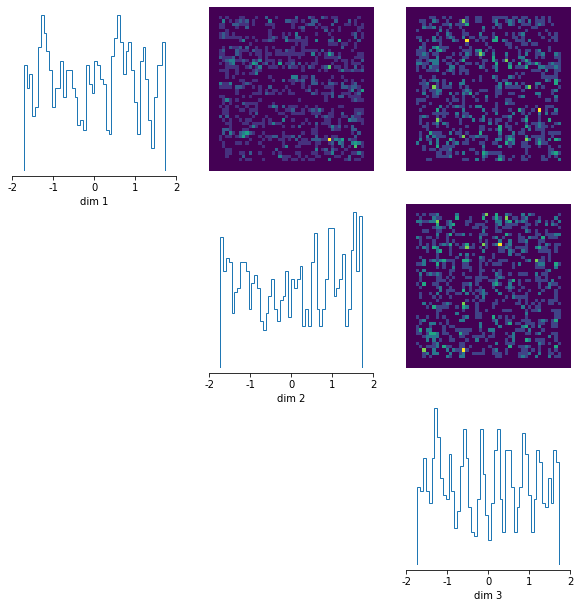

In [44]:
_ = utils.pairplot(starting_samples.detach().numpy(), limits=[[-2,2],[-2,2],[-2,2]],)

In [45]:
trained_vi_net = train_vi(vi_net_, posterior, batch_size=1000)

/home/michael/Documents/sbi/sbi/inference/posterior.py:247: UserWarning: The log probability from SNL is only correct up to a normalizing constant.
  warn(


loss:    tensor(9.2781, grad_fn=<MeanBackward0>)
loss:    tensor(9.2651, grad_fn=<MeanBackward0>)
loss:    tensor(9.4101, grad_fn=<MeanBackward0>)
loss:    tensor(9.2102, grad_fn=<MeanBackward0>)
loss:    tensor(9.4217, grad_fn=<MeanBackward0>)
loss:    tensor(9.3805, grad_fn=<MeanBackward0>)
loss:    tensor(9.2163, grad_fn=<MeanBackward0>)
loss:    tensor(9.1734, grad_fn=<MeanBackward0>)
loss:    tensor(9.0715, grad_fn=<MeanBackward0>)
loss:    tensor(9.3475, grad_fn=<MeanBackward0>)
loss:    tensor(9.1206, grad_fn=<MeanBackward0>)
loss:    tensor(9.1421, grad_fn=<MeanBackward0>)
loss:    tensor(9.0159, grad_fn=<MeanBackward0>)
loss:    tensor(9.3504, grad_fn=<MeanBackward0>)
loss:    tensor(8.9771, grad_fn=<MeanBackward0>)
loss:    tensor(9.1591, grad_fn=<MeanBackward0>)
loss:    tensor(9.1010, grad_fn=<MeanBackward0>)
loss:    tensor(9.1915, grad_fn=<MeanBackward0>)
loss:    tensor(9.2299, grad_fn=<MeanBackward0>)
loss:    tensor(9.1231, grad_fn=<MeanBackward0>)
loss:    tensor(9.00

In [46]:
output_samples = trained_vi_net.sample(10000)

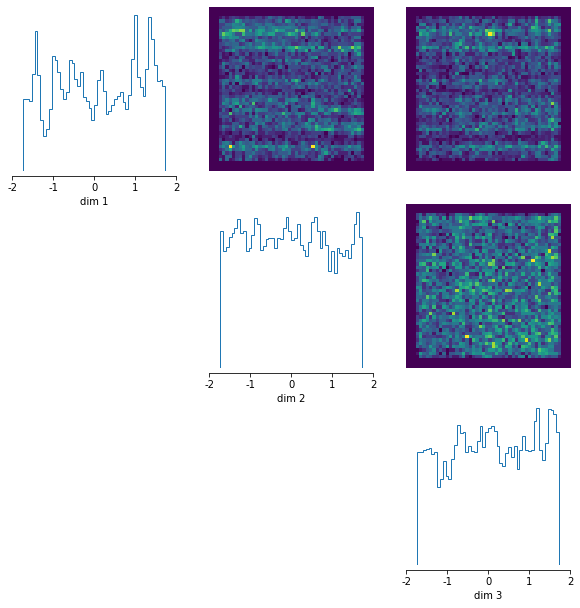

In [47]:
_ = utils.pairplot(output_samples.detach().numpy(), limits=[[-2,2],[-2,2],[-2,2]],)